## **Preparing Data**

In [1]:
!apt install python3.7
!pip install -U torchtext==0.6.0
!python -m spacy download en
!python -m spacy download de

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3.7 is already the newest version (3.7.13-1+bionic3).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.0 MB/s 
     |████████████████████████████████| 1.2 MB 10.4 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 2.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import spacy
import numpy as np

import random
import math
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### **Tokenizers**
- We convert sentences to individual tokens by using tokenizers.
  - e.g. "good morning!" becomes ["good", "morning", "!"]
- We will use python package `spaCy` for this

In [3]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [4]:
def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]

We use Field library to process data. By setting batch_first = True, we set the batch dimension comes first.

In [5]:
SRC = Field(tokenize= tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

TRG = Field(tokenize= tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

We use Multi30k dataset of about 30k English, Deutch, and French sentences, and each sentence has 12 words. We set exts as the langauges for source and target languages.

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts= ('.de', '.en'),
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:01<00:00, 921kB/s] 


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 229kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 221kB/s]


In [7]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


In [8]:
print(len(vars(train_data.examples[0])['src']))
print(len(vars(train_data.examples[1])['src']))

print(vars(train_data.examples[0]))
print(vars(train_data.examples[1]))

13
8
{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}
{'src': ['mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem', '.'], 'trg': ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.']}


## **Build Vocabulary**
- We use `build_vocab` function to get indexing of tokens. Note that the vocabularies of source and target are different. 
- We use `min_freq` to have words that appear at least twice in the corpus to add to the vocabulary. So the word that apears only once will convert to <unk> token. 
- Note that we have to use only training set to build the vocabulary, neither validation nor test set.

In [9]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [10]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7855
Unique tokens in target (en) vocabulary: 5893


### Create the iterators
- we use `BucketIterator` to pack tokens as a batch and convert tokens to indices.

In [11]:
# for using GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device
)

## **Building the Model**

### Encoder
 - For positional encoding, we use postional embedding as in BERT unlike the positional encoding in the original Transformer paper.

In [13]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        ''' Input Embedding '''
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        ''' Multiple Encoder Layers '''
        # we use multiple encoder layers (e.g., 6 in the original Transformer paper)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
      batch_size = src.shape[0]
      src_len = src.shape[1]

      pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

      src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

      for layer in self.layers:
        src = layer(src, src_mask)

      return src 

### Encoer layer

In [14]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        ''' Multi Head self-Attention '''        
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positional FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        _src = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))
        return src

### Multi Head Attention Layer

In [15]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
      super().__init__()

      assert hid_dim % n_heads == 0

      self.hidden_dim = hid_dim 
      self.n_heads = n_heads 
      self.head_dim = hid_dim // n_heads 

      self.fc_q = nn.Linear(hid_dim, hid_dim)
      self.fc_k = nn.Linear(hid_dim, hid_dim) 
      self.fc_v = nn.Linear(hid_dim, hid_dim)

      self.fc_o = nn.Linear(hid_dim, hid_dim)

      self.dropout = nn.Dropout(dropout)

      self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
        
    def forward(self, query, key, value, mask = None):
      batch_size = query.shape[0]

      Q = self.fc_q(query)
      K = self.fc_k(key)
      V = self.fc_v(value)

      Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
      K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
      V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)  

      energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

      if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)
      
      attention = torch.softmax(energy, dim=-1)

      x = torch.matmul(self.dropout(attention), V)
      x = x.permute(0, 2, 1, 3).contiguous()
      x = x.view(batch_size, -1, self.hidden_dim)
      x = self.fc_o(x)
      
      return x, attention

### Position-wise Feedforward Layer

In [16]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)        
        return x

### Decoder 

In [17]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

       
        
    def forward(self,trg, enc_src, trg_mask, src_mask):

      output = self.fc_out(enc_src)
      batch_size = trg.shape[0]
      trg_len = trg.shape[1]
      pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)


      trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))



      for layer in self.layers:
          trg, attention = layer(trg, enc_src, trg_mask, src_mask)



      output = self.fc_out(trg)
      return output, attention
       

### Decoder Layer

In [18]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        ''' Multi Head self Attention'''
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Encoder-decoder attention'''
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positionwise FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
       # TODO: write your code
       _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
       trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
       _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

       trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
       _trg = self.positionwise_feedforward(trg)
       trg = self.ff_layer_norm(trg + self.dropout(_trg))


       
        
       return trg, attention

### Sequence-to-sequence model

In [19]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask


    def make_trg_mask(self, trg):

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask

        return trg_mask


    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        ## TODO: write down the forward step 
        enc_src = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
                
        return output, attention

### Training the Seq2Seq Model

In [20]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1


enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [21]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,853 trainable parameters


We initialize model weights

In [23]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

We use Adam as our optimizer and CrossEntropyLoss. Also we set to ignore <pad> token in calculating loss

In [24]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [25]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### Training

In [26]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)

        trg = trg[:,1:].contiguous().view(-1)
        loss = criterion(output, trg)
        loss.backward()

        optimizer.step()
        
       
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### Evaluation

In [27]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg
            output, _ = model(src, trg[:,:-1])
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [28]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Train the model through multiple epochs

In [29]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 16s
	Train Loss: 4.329
	 Val. Loss: 3.111
Epoch: 02 | Time: 0m 16s
	Train Loss: 2.872
	 Val. Loss: 2.322
Epoch: 03 | Time: 0m 16s
	Train Loss: 2.251
	 Val. Loss: 1.977
Epoch: 04 | Time: 0m 17s
	Train Loss: 1.884
	 Val. Loss: 1.807
Epoch: 05 | Time: 0m 17s
	Train Loss: 1.628
	 Val. Loss: 1.701
Epoch: 06 | Time: 0m 17s
	Train Loss: 1.437
	 Val. Loss: 1.648
Epoch: 07 | Time: 0m 16s
	Train Loss: 1.283
	 Val. Loss: 1.621
Epoch: 08 | Time: 0m 16s
	Train Loss: 1.153
	 Val. Loss: 1.613
Epoch: 09 | Time: 0m 16s
	Train Loss: 1.046
	 Val. Loss: 1.629
Epoch: 10 | Time: 0m 16s
	Train Loss: 0.953
	 Val. Loss: 1.637


In [30]:
model.load_state_dict(torch.load('my-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f}')

| Test Loss: 1.671


### Inference and attention visualization

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [32]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    logging = True
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    if logging:
        print(f"Entire SRC tokens: {tokens}")

    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    if logging:
        print(f"SRC tokens index: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)


    src_mask = model.make_src_mask(src_tensor)


    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)


    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)


        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)


        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)


        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break

    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    
    return trg_tokens[1:], attention

In [42]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads

    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')
        
        # Set up axes
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        # Show label at every tick
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


In [43]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [44]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

Entire SRC tokens: ['<sos>', 'ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.', '<eos>']
SRC tokens index: [2, 5, 171, 32, 124, 24, 71, 32, 1035, 4, 3]
predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'the', 'black', 'dog', '.', '<eos>']


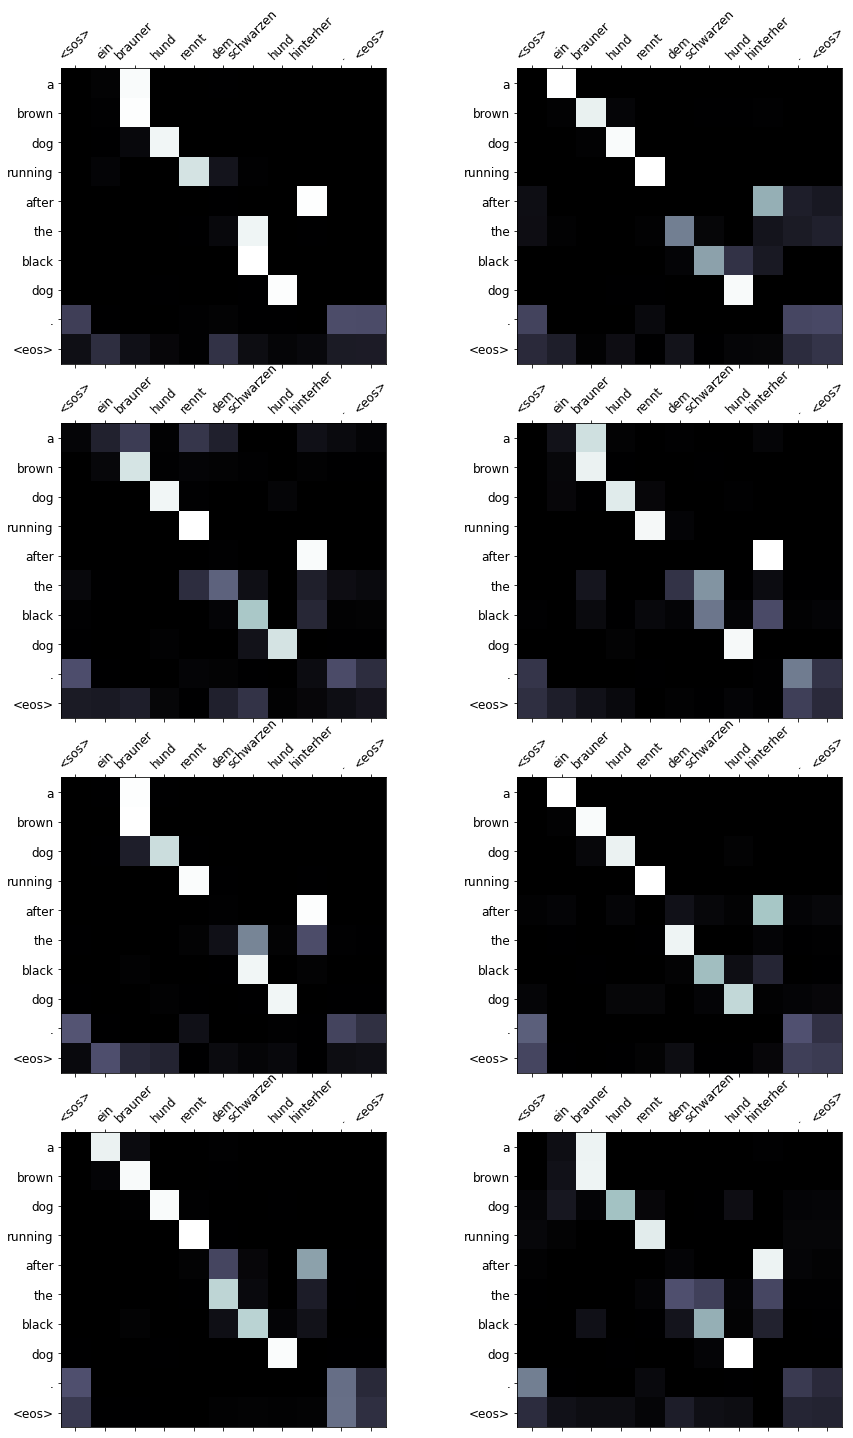

In [45]:
display_attention(src, translation, attention)

### BLEU
- Calculate BLEU for test set

In [37]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [38]:
bleu_score_ = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

Entire SRC tokens: ['<sos>', 'ein', 'mann', 'mit', 'einem', 'orangefarbenen', 'hut', ',', 'der', 'etwas', 'anstarrt', '.', '<eos>']
SRC tokens index: [2, 5, 13, 11, 6, 175, 106, 9, 15, 75, 0, 4, 3]
Entire SRC tokens: ['<sos>', 'ein', 'boston', 'terrier', 'läuft', 'über', 'saftig-grünes', 'gras', 'vor', 'einem', 'weißen', 'zaun', '.', '<eos>']
SRC tokens index: [2, 5, 3652, 4153, 83, 42, 0, 118, 27, 6, 51, 320, 4, 3]
Entire SRC tokens: ['<sos>', 'ein', 'mädchen', 'in', 'einem', 'karateanzug', 'bricht', 'ein', 'brett', 'mit', 'einem', 'tritt', '.', '<eos>']
SRC tokens index: [2, 5, 25, 7, 6, 2897, 2784, 5, 1276, 11, 6, 402, 4, 3]
Entire SRC tokens: ['<sos>', 'fünf', 'leute', 'in', 'winterjacken', 'und', 'mit', 'helmen', 'stehen', 'im', 'schnee', 'mit', 'schneemobilen', 'im', 'hintergrund', '.', '<eos>']
SRC tokens index: [2, 216, 73, 7, 5320, 10, 11, 827, 52, 20, 123, 11, 0, 20, 86, 4, 3]
Entire SRC tokens: ['<sos>', 'leute', 'reparieren', 'das', 'dach', 'eines', 'hauses', '.', '<eos>']


In [40]:
translation,attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

Entire SRC tokens: ['<sos>', 'ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.', '<eos>']
SRC tokens index: [2, 5, 171, 32, 124, 24, 71, 32, 1035, 4, 3]
predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'the', 'black', 'dog', '.', '<eos>']


src = ['ein', 'kleines', 'kind', 'steht', 'allein', 'auf', 'einem', 'zerklüfteten', 'felsen', '.']
trg = ['a', 'young', 'child', 'is', 'standing', 'alone', 'on', 'some', 'jagged', 'rocks', '.']
Entire SRC tokens: ['<sos>', 'ein', 'kleines', 'kind', 'steht', 'allein', 'auf', 'einem', 'zerklüfteten', 'felsen', '.', '<eos>']
SRC tokens index: [2, 5, 66, 49, 29, 966, 12, 6, 0, 214, 4, 3]
predicted trg = ['a', 'young', 'child', 'stands', 'alone', 'on', 'a', 'rock', '.', '<eos>']


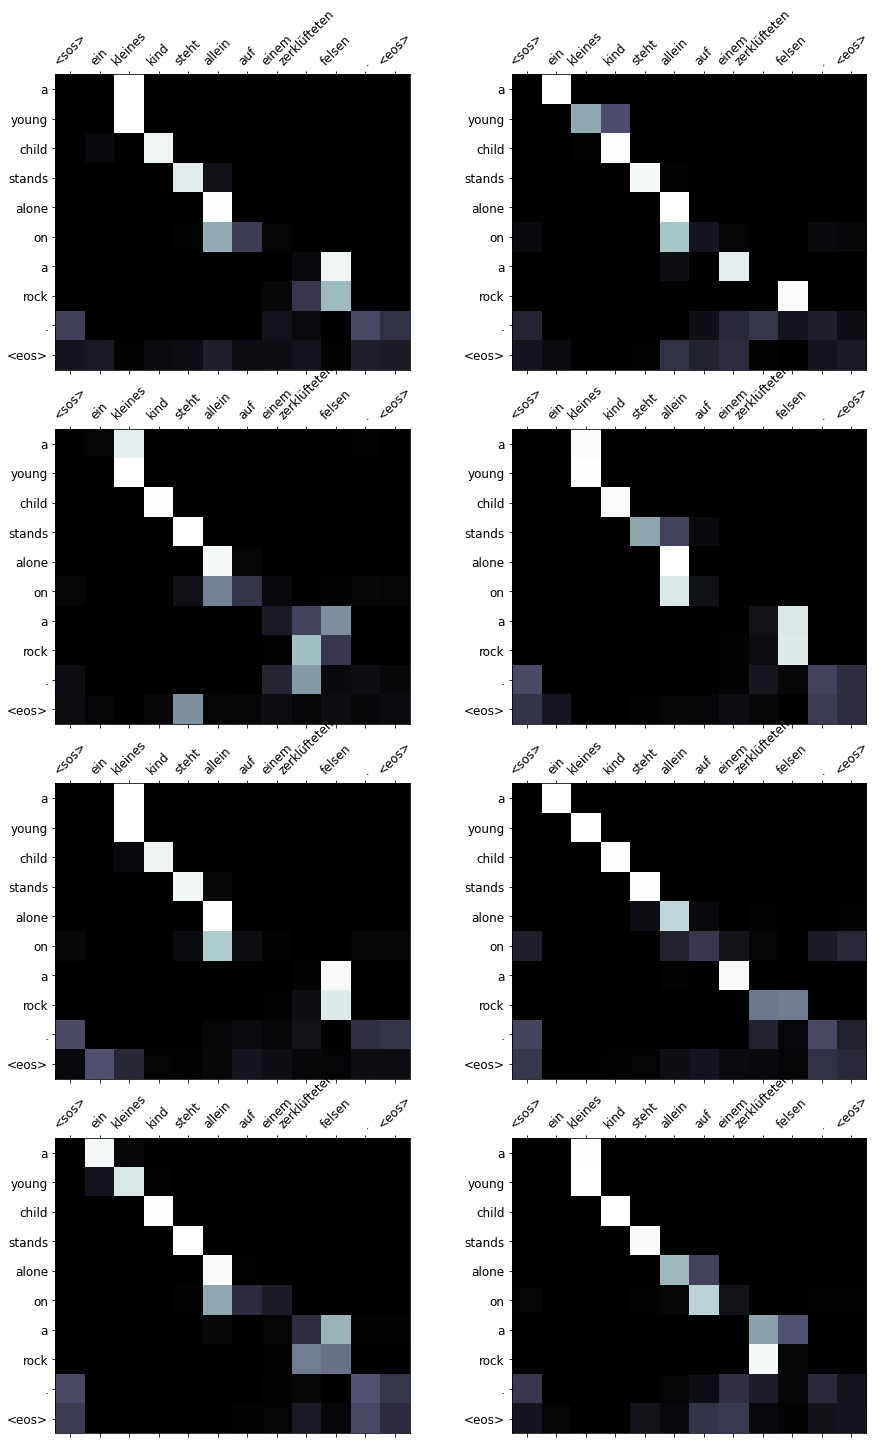

In [46]:
example_idx = 10

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation,attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
display_attention(src, translation, attention)

src = ['eine', 'frau', 'sitzt', 'bei', 'ihrem', 'trockenblumensortiment', 'auf', 'einem', 'freiluftmarkt', '.']
trg = ['a', 'woman', 'is', 'sitting', 'by', 'her', 'dried', 'flower', 'display', 'at', 'an', 'outside', 'market', '.']
Entire SRC tokens: ['<sos>', 'eine', 'frau', 'sitzt', 'bei', 'ihrem', 'trockenblumensortiment', 'auf', 'einem', 'freiluftmarkt', '.', '<eos>']
SRC tokens index: [2, 8, 16, 31, 59, 172, 0, 12, 6, 3740, 4, 3]
predicted trg = ['a', 'woman', 'sits', 'at', 'her', 'outdoor', 'market', 'at', 'an', 'open', 'market', '.', '<eos>']


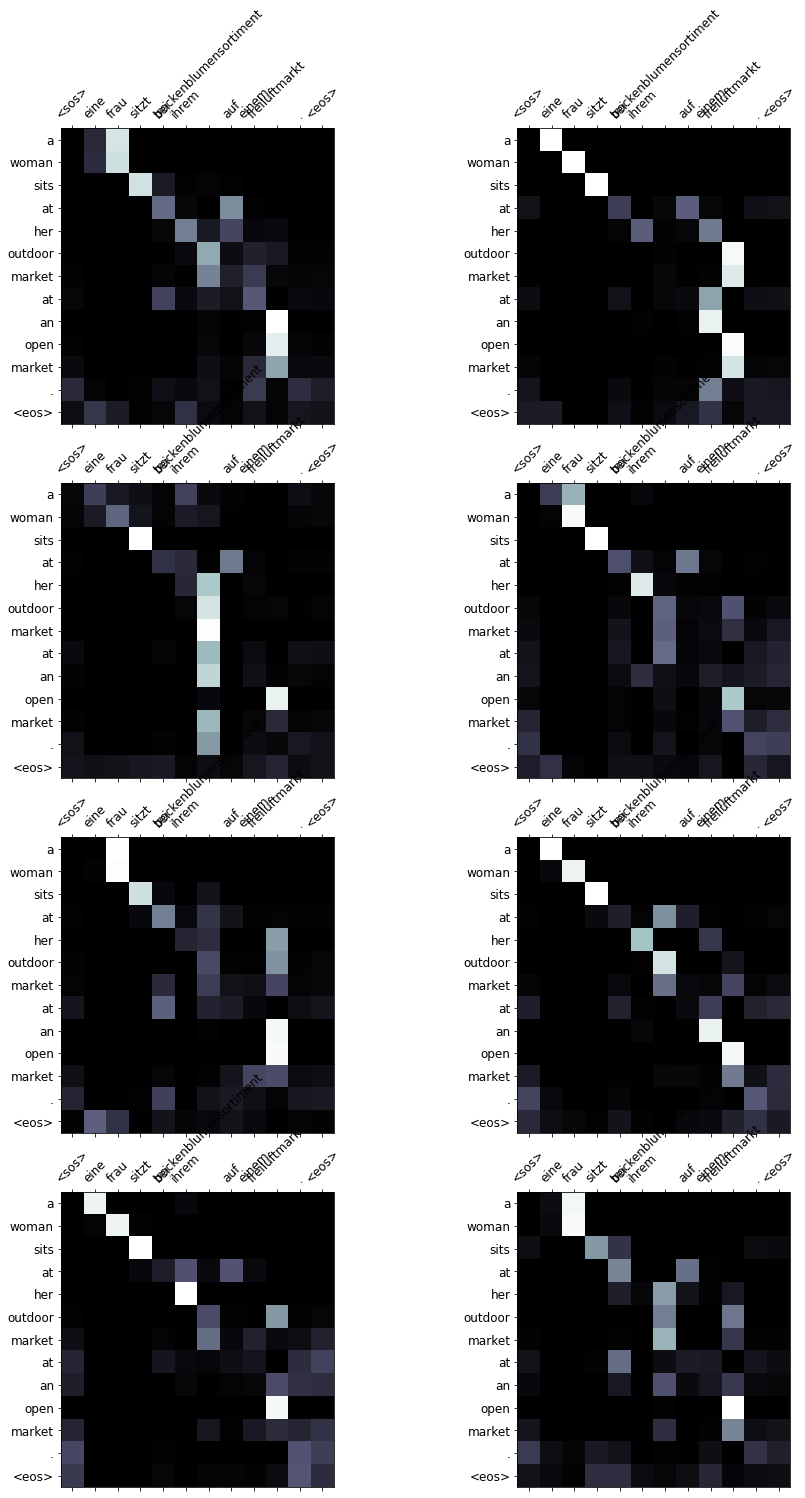

In [47]:
example_idx = 13

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation,attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')
display_attention(src, translation, attention)

## B

In [146]:
class TunedMultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
      super().__init__()

      assert hid_dim % n_heads == 0

      self.hidden_dim = hid_dim 
      self.n_heads = n_heads 
      self.head_dim = hid_dim // n_heads 

      self.fc_q = nn.Linear(hid_dim, hid_dim)
      self.qkv_batch_norm = nn.BatchNorm1d(hid_dim)
      self.fc_k = nn.Linear(hid_dim, hid_dim) 
      self.fc_v = nn.Linear(hid_dim, hid_dim)
      self.fc_o = nn.Linear(hid_dim, hid_dim)

      self.dropout = nn.Dropout(dropout)

      self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
        
    def forward(self, query, key, value, mask = None):
      batch_size = query.shape[0]

      Q = self.fc_q(query)
      K = self.fc_k(key)
      V = self.fc_v(value)

      Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
      K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
      V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)  

      energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

      if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)
      
      attention = torch.softmax(energy, dim=-1)

      x = torch.matmul(self.dropout(attention), V)
      x = x.permute(0, 2, 1, 3).contiguous()
      x = x.view(batch_size, -1, self.hidden_dim)
      x = self.fc_o(x)
      
      return x, attention

In [147]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask


    def make_trg_mask(self, trg):

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask

        return trg_mask


    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        ## TODO: write down the forward step 
        enc_src = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
                
        return output, attention

In [148]:
class TunedDecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        ''' Multi Head self Attention'''
        self.self_attention = TunedMultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Encoder-decoder attention'''
        self.encoder_attention = TunedMultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positionwise FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
       # TODO: write your code
       _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
       trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
       _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

       trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
       _trg = self.positionwise_feedforward(trg)
       trg = self.ff_layer_norm(trg + self.dropout(_trg))


       
        
       return trg, attention

In [149]:
class TunedEncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        ''' Multi Head self-Attention '''        
        self.self_attention = TunedMultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)

        ''' Positional FeedForward Layer'''
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)

        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        _src = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))
        return src

In [150]:
class TunedEncoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        ''' Input Embedding '''
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        ''' Multiple Encoder Layers '''
        # we use multiple encoder layers (e.g., 6 in the original Transformer paper)
        self.layers = nn.ModuleList([TunedEncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
      batch_size = src.shape[0]
      src_len = src.shape[1]

      pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

      src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

      for layer in self.layers:
        src = layer(src, src_mask)

      return src 

In [151]:
class TunedDecoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([TunedDecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

       
        
    def forward(self,trg, enc_src, trg_mask, src_mask):

      output = self.fc_out(enc_src)
      batch_size = trg.shape[0]
      trg_len = trg.shape[1]
      pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)


      trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))



      for layer in self.layers:
          trg, attention = layer(trg, enc_src, trg_mask, src_mask)



      output = self.fc_out(trg)
      return output, attention
       

In [186]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def make_src_mask(self, src):

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_trg_mask(self, trg):

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask

        return trg_mask


    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        ## TODO: write down the forward step 
        enc_src = self.encoder(src, src_mask)
        combinedenc_src = enc_src+(self.sigmoid(enc_src)+self.tanh(enc_src))/2
        output, attention = self.decoder(trg, combinedenc_src, trg_mask, src_mask)
                
        return output, attention

In [187]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1


enc = TunedEncoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = TunedDecoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [194]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

tmodel = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [195]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,041,925 trainable parameters


In [196]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

tmodel.apply(initialize_weights);

In [197]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(tmodel.parameters(), lr = LEARNING_RATE)

In [198]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [199]:
N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(tmodel, train_iterator, optimizer, criterion)
    valid_loss = evaluate(tmodel, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'my-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Time: 0m 17s
	Train Loss: 4.381
	 Val. Loss: 3.162
Epoch: 02 | Time: 0m 18s
	Train Loss: 2.929
	 Val. Loss: 2.383
Epoch: 03 | Time: 0m 17s
	Train Loss: 2.294
	 Val. Loss: 1.988
Epoch: 04 | Time: 0m 17s
	Train Loss: 1.918
	 Val. Loss: 1.804
Epoch: 05 | Time: 0m 16s
	Train Loss: 1.659
	 Val. Loss: 1.709
Epoch: 06 | Time: 0m 17s
	Train Loss: 1.467
	 Val. Loss: 1.653
Epoch: 07 | Time: 0m 17s
	Train Loss: 1.310
	 Val. Loss: 1.634
Epoch: 08 | Time: 0m 17s
	Train Loss: 1.182
	 Val. Loss: 1.630
Epoch: 09 | Time: 0m 17s
	Train Loss: 1.075
	 Val. Loss: 1.633
Epoch: 10 | Time: 0m 17s
	Train Loss: 0.976
	 Val. Loss: 1.639


In [205]:
from torchtext.data.metrics import bleu_score
bleu_score__ = calculate_bleu(test_data, SRC, TRG, tmodel, device)

print(f'BLEU score = {bleu_score__*100:.2f}')

Entire SRC tokens: ['<sos>', 'ein', 'mann', 'mit', 'einem', 'orangefarbenen', 'hut', ',', 'der', 'etwas', 'anstarrt', '.', '<eos>']
SRC tokens index: [2, 5, 13, 11, 6, 175, 106, 9, 15, 75, 0, 4, 3]
Entire SRC tokens: ['<sos>', 'ein', 'boston', 'terrier', 'läuft', 'über', 'saftig-grünes', 'gras', 'vor', 'einem', 'weißen', 'zaun', '.', '<eos>']
SRC tokens index: [2, 5, 3652, 4153, 83, 42, 0, 118, 27, 6, 51, 320, 4, 3]
Entire SRC tokens: ['<sos>', 'ein', 'mädchen', 'in', 'einem', 'karateanzug', 'bricht', 'ein', 'brett', 'mit', 'einem', 'tritt', '.', '<eos>']
SRC tokens index: [2, 5, 25, 7, 6, 2897, 2784, 5, 1276, 11, 6, 402, 4, 3]
Entire SRC tokens: ['<sos>', 'fünf', 'leute', 'in', 'winterjacken', 'und', 'mit', 'helmen', 'stehen', 'im', 'schnee', 'mit', 'schneemobilen', 'im', 'hintergrund', '.', '<eos>']
SRC tokens index: [2, 216, 73, 7, 5320, 10, 11, 827, 52, 20, 123, 11, 0, 20, 86, 4, 3]
Entire SRC tokens: ['<sos>', 'leute', 'reparieren', 'das', 'dach', 'eines', 'hauses', '.', '<eos>']
